In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import scipy.misc
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.applications.densenet import DenseNet169
from keras.applications import imagenet_utils

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [ ]:
def prepare_image(image, target):
    # if the image mode is not RGB, convert it
    if image.mode != "RGB":
        image = image.convert("RGB")

    # resize the input image and preprocess it
    image = image.resize(target)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image, mode='torch')
 
     # return the processed image
    return image

In [ ]:
def load_dataset():
    train_dataset = h5py.File('/content/drive/My Drive/Datasets/SIRI-WHU/Train_SIRI-WHU.h5', 'r')
    train_set_x_orig = np.array(train_dataset["X_train_dataset"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["Y_train_dataset"][:]) # your train set labels

    test_dataset = h5py.File('/content/drive/My Drive/Datasets/SIRI-WHU/Test_SIRI-WHU.h5', 'r')
    test_set_x_orig = np.array(test_dataset["X_test_dataset"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["Y_test_dataset"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
# Loading the data (Dataset)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


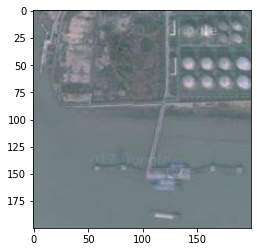

In [ ]:
#for i in range(X_train_orig.shape[0]):
#  X_train_orig[i] = Image.fromarray(X_train_orig[i].astype(np.uint8)).convert(mode='HSV')
#  X_train_orig[i] = Image.fromarray(X_train_orig[i].astype(np.uint8)).convert(mode='YCbCr')

#for j in range(X_test_orig.shape[0]):
#  X_test_orig[j] = Image.fromarray(X_test_orig[j].astype(np.uint8)).convert(mode='HSV')
#  X_test_orig[j] = Image.fromarray(X_test_orig[j].astype(np.uint8)).convert(mode='YCbCr')

index = 50
plt.imshow(Image.fromarray(X_train_orig[index], mode='RGB'))
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [ ]:
Y_train = convert_to_one_hot(Y_train_orig, 12)
Y_test = convert_to_one_hot(Y_test_orig, 12)
XXtrain = np.zeros((X_train_orig.shape[0], 224, 224, 3))
XXtest = np.zeros((X_test_orig.shape[0], 224, 224, 3))

for i in range(X_train_orig.shape[0]):
     XXtrain[i] = prepare_image(Image.fromarray(X_train_orig[i],mode='RGB'), target=(224,224))

for j in range(X_test_orig.shape[0]):
     XXtest[j] = prepare_image(Image.fromarray(X_test_orig[j], mode='RGB'), target=(224,224))

print ("number of training examples = " + str(X_train_orig.shape[0]))
print ("number of test examples = " + str(X_test_orig.shape[0]))
print ("X_train shape: " + str(X_train_orig.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test_orig.shape))
print ("Y_test shape: " + str(Y_test.shape))

print ("XXtrain shape: " + str(XXtrain.shape))
print ("XXtest shape: " + str(XXtest.shape))

number of training examples = 1920
number of test examples = 480
X_train shape: (1920, 200, 200, 3)
Y_train shape: (1920, 12)
X_test shape: (480, 200, 200, 3)
Y_test shape: (480, 12)
XXtrain shape: (1920, 224, 224, 3)
XXtest shape: (480, 224, 224, 3)


In [ ]:
print ("XXtrain shape: " + str(XXtrain.shape))
print ("XXtest shape: " + str(XXtest.shape))

pretrained_model = DenseNet169(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

#pretrained_model.save_weights(filepath='/content/drive/My Drive/Datasets/PretrainedModels/DenseNetWts.h5')

pretrained_model1 = models.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[-2].output)

ot = layers.Dense(1000)(pretrained_model1.output)
pretrained_model2 = models.Model(inputs=pretrained_model1.input, outputs=ot)

pretrained_model2.load_weights(filepath='/content/drive/My Drive/Datasets/PretrainedModels/DenseNetWts.h5')

print(pretrained_model2.summary())

Txtrain = pretrained_model2.predict(XXtrain)
Txtest = pretrained_model2.predict(XXtest)

print("Txtrain Shape:", Txtrain.shape)
print("Txtest Shape:", Txtest.shape)

Desnet_Out = h5py.File('/content/drive/My Drive/Datasets/SIRI-WHU/Convout/Desnet_Out.h5', 'w')
train_desnetout = Desnet_Out.create_dataset("train_OutDesnet", np.shape(Txtrain), h5py.h5t.IEEE_F64BE, data=Txtrain)
test_desnetout = Desnet_Out.create_dataset("test_OutDesnet", np.shape(Txtest), h5py.h5t.IEEE_F64BE, data=Txtest)
Desnet_Out.close()

XXtrain shape: (1920, 224, 224, 3)
XXtest shape: (480, 224, 224, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________

In [ ]:
Desnet_Out = h5py.File('/content/drive/My Drive/Datasets/SIRI-WHU/Convout/F1000/Desnet_Out.h5', 'r')
Txtrain111 = np.array(Desnet_Out["train_OutDesnet"][:])
Txtest111 = np.array(Desnet_Out["test_OutDesnet"][:])
Desnet_Out.close()

print(Txtrain[8])
print(np.sum(Txtrain[8]))
print("----------------------------------------------------")
print(Txtrain111[8])
print(np.sum(Txtrain111[8]))

[ 8.73398483e-01 -2.06958580e+00 -8.96693110e-01  9.97926950e-01
 -7.44030237e-01  3.59464258e-01  3.00103736e+00 -2.54490113e+00
 -2.45473504e+00 -2.05583286e+00 -2.50475812e+00 -5.03117132e+00
 -3.34203362e+00 -4.17517853e+00 -2.67257237e+00 -3.42000651e+00
 -1.78212357e+00 -2.69415498e+00 -2.37278318e+00 -2.65780425e+00
 -2.87061477e+00 -6.46051526e-01 -5.06752491e-01 -1.67874777e+00
 -1.93444443e+00 -3.06139779e+00  1.78098813e-01 -4.14416838e+00
 -2.08489037e+00 -2.12038589e+00 -1.06772363e+00 -3.28466463e+00
 -1.24473774e+00  2.60581756e+00  1.49214172e+00  2.08540630e+00
  2.61320686e+00 -6.56003058e-01  1.05781889e+00 -9.35026646e-01
 -2.20195985e+00 -7.29114115e-02 -4.99719667e+00 -1.22414327e+00
 -9.73566890e-01 -3.60066622e-01 -1.89921010e+00  1.67702246e+00
 -6.47741318e-01 -1.28158927e+00 -1.40285289e+00  9.93255913e-01
  6.88501477e-01  1.52629292e+00  8.11410069e-01  1.95372367e+00
  3.60948145e-01  2.20856118e+00  2.91990352e+00  3.06486082e+00
  2.76985765e+00  2.76071

In [ ]:
print(Txtrain[8]-Txtrain111[8])
print(np.sum(Txtrain[8]-Txtrain111[8]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.